# <신용카드 고객 분석 및 이탈고객 예측>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import show
import warnings
warnings.filterwarnings(action = 'ignore')

# 1. 데이터 확인

In [2]:
df = pd.read_csv('./data/BankChurners/BankChurners.csv')

In [3]:
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


### 컬럼 정보

- CLIENTNUM ------------------ 클라이언트 고유번호
- Attrition_Flag ------------------ 계정이 존재/폐쇄 여부
- Customer_Age --------------- 고객의 연령
- Gender -------------------------- M = 남성, F = 여성
- Dependent_count ------------ 부양 가족 수 
- Education_Level ------------- 계좌 소유자의 최종 학력             
- Marital_Status ---------------- 기혼, 미혼, 이혼, 알 수 없음               
- Income_Category ------------ 계정 소유자의 연간 소득 범주
- Card_Category --------------- 카드 유형 (블루, 실버, 골드, 플래티넘)         
- Months_on_book ------------- 은행과의 거래 기간(월)
- Total_Relationship_Count -- 고객이 보유한 카드 수
- Months_Inactive_12_mon -- 지난 12 개월 동안 비활성 상태인 개월 수
- Contacts_Count_12_mon -- 지난 12 개월 동안의 연락처 수      
- Credit_Limit -------------------- 신용 카드 신용 한도
- Total_Revolving_Bal --------- 신용 카드의 총 잔액         
- Avg_Open_To_Buy ---------- 신용 한도 구매 가능 금액 (지난 12 개월 평균)
- Total_Amt_Chng_Q4_Q1 -- 거래 금액의 변동 (Q1 대비 Q4)
- Total_Trans_Amt ------------- 총 거래 금액 (지난 12 개월)
- Total_Trans_Ct --------------- 총 거래 수 (지난 12 개월)    
- Total_Ct_Chng_Q4_Q1 ---- 거래 건수 변경 (Q1 대비 Q4)   
- Avg_Utilization_Ratio ------- 평균 카드 사용률

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

데이터는 10127개의 행과 21개의 열로 이루어져 있다.

In [5]:
# NaN 값이 있는지 확인
df.isnull().sum()

CLIENTNUM                   0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

# 2. EDA

In [6]:
from matplotlib import font_manager, rc
import platform

# 이미지에 한글 표시 설정
if platform.system() == 'Windows': # 윈도우인 경우 맑은고딕
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else :  # Mac인 경우 애플고딕
    rc('font', family='AppleGothic')

# 그래프에서 마이너스 기호가 표시되도록 하는 설정
matplotlib.rcParams['axes.unicode_minus'] = False

- 고객 연령은 40대가 가장 많다.

## 2.1. 범주형 데이터 EDA

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Less than $40K'),
  Text(1, 0, '$40K - $60K'),
  Text(2, 0, '$60K - $80K'),
  Text(3, 0, '$80K - $120K'),
  Text(4, 0, '$120K +'),
  Text(5, 0, 'Unknown')])

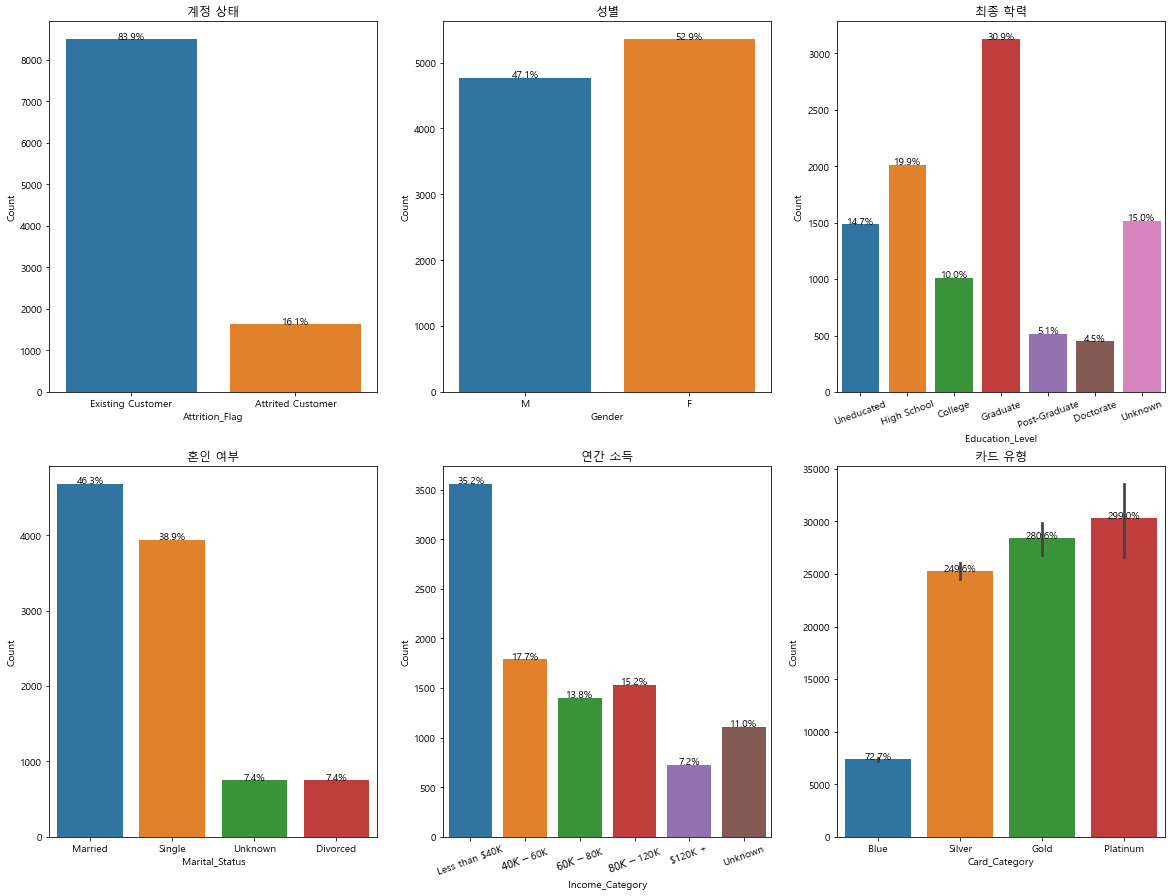

In [37]:
# 각 변수에 알리아스를 지정해서 그래프 그리기
figure, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(20,15)

sns.countplot(data=df, x='Attrition_Flag', ax=ax1)
sns.countplot(data=df, x='Gender', ax=ax2)
sns.countplot(data=df, x='Education_Level', ax=ax3,
              order=["Uneducated", "High School", "College", "Graduate", "Post-Graduate", "Doctorate", "Unknown"])
sns.countplot(data=df, x='Marital_Status', ax=ax4)
sns.countplot(data=df, x='Income_Category', ax=ax5, 
              order=["Less than $40K", "$40K - $60K", "$60K - $80K", "$80K - $120K", "$120K +", "Unknown"])
sns.countplot(data=df, x='Card_Category', ax=ax6,
              order=["Blue", "Silver", "Gold", "Platinum"])

# % 표현
total = float(len(df))
ax = [ax1, ax2, ax3, ax4, ax5, ax6]
for i in ax:
    for p in i.patches:
        height = p.get_height()
        i.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.1f}%'.format(100 * height/total),
                ha="center") 


# 제목 추가
ax1.set(ylabel='Count', title='계정 상태')
ax2.set(ylabel='Count', title='성별')
ax3.set(ylabel='Count', title='최종 학력')
ax4.set(ylabel='Count', title='혼인 여부')
ax5.set(ylabel='Count', title='연간 소득')
ax6.set(ylabel='Count', title='카드 유형')


plt.sca(ax3)
plt.xticks(rotation=20)
plt.sca(ax5)
plt.xticks(rotation=20)

## 2.2. 연속형 데이터 EDA

[Text(0.5, 1.0, '지난 12개월 동안의 연락처 수')]

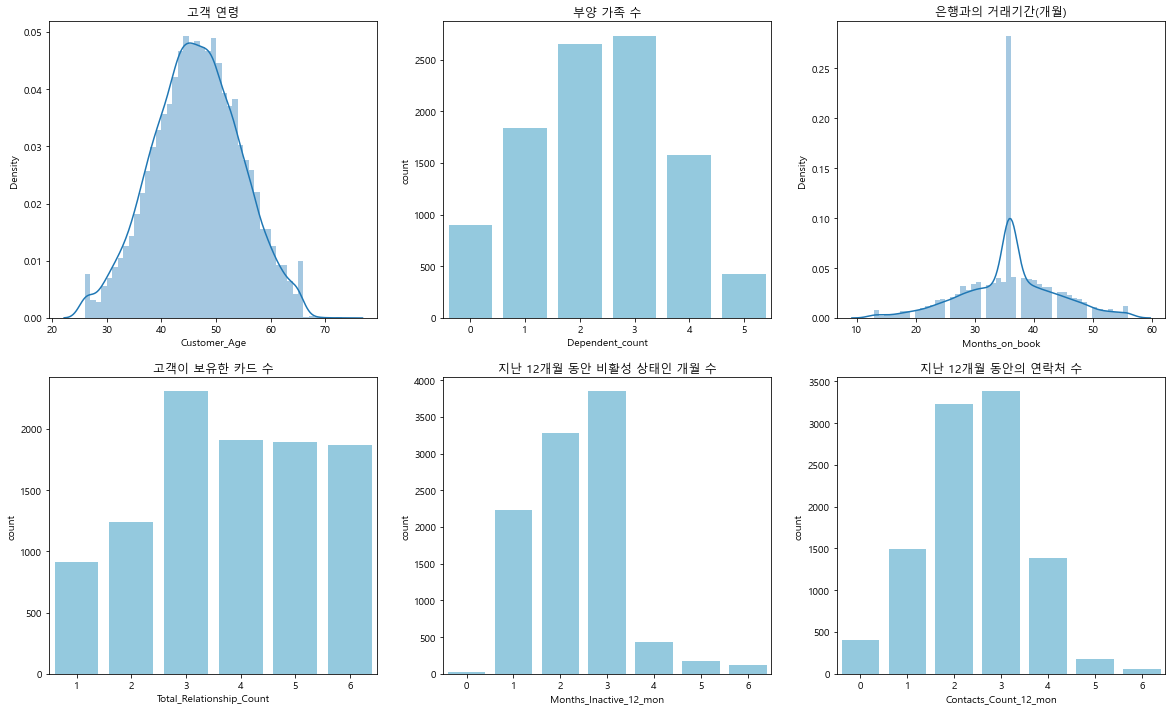

In [8]:
figure, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(20,12)

sns.distplot(df['Customer_Age'], ax=ax1)
sns.countplot(data=df, x='Dependent_count', ax=ax2, color="skyblue")
sns.distplot(df['Months_on_book'], ax=ax3)
sns.countplot(data=df, x='Total_Relationship_Count', ax=ax4, color="skyblue")
sns.countplot(data=df, x='Months_Inactive_12_mon', ax=ax5, color="skyblue")
sns.countplot(data=df, x='Contacts_Count_12_mon', ax=ax6, color="skyblue")

ax1.set(title='고객 연령')
ax2.set(title='부양 가족 수')
ax3.set(title='은행과의 거래기간(개월)')
ax4.set(title='고객이 보유한 카드 수')
ax5.set(title='지난 12개월 동안 비활성 상태인 개월 수')
ax6.set(title='지난 12개월 동안의 연락처 수')

[Text(0.5, 1.0, '지난 12개월 동안의 연락처 수')]

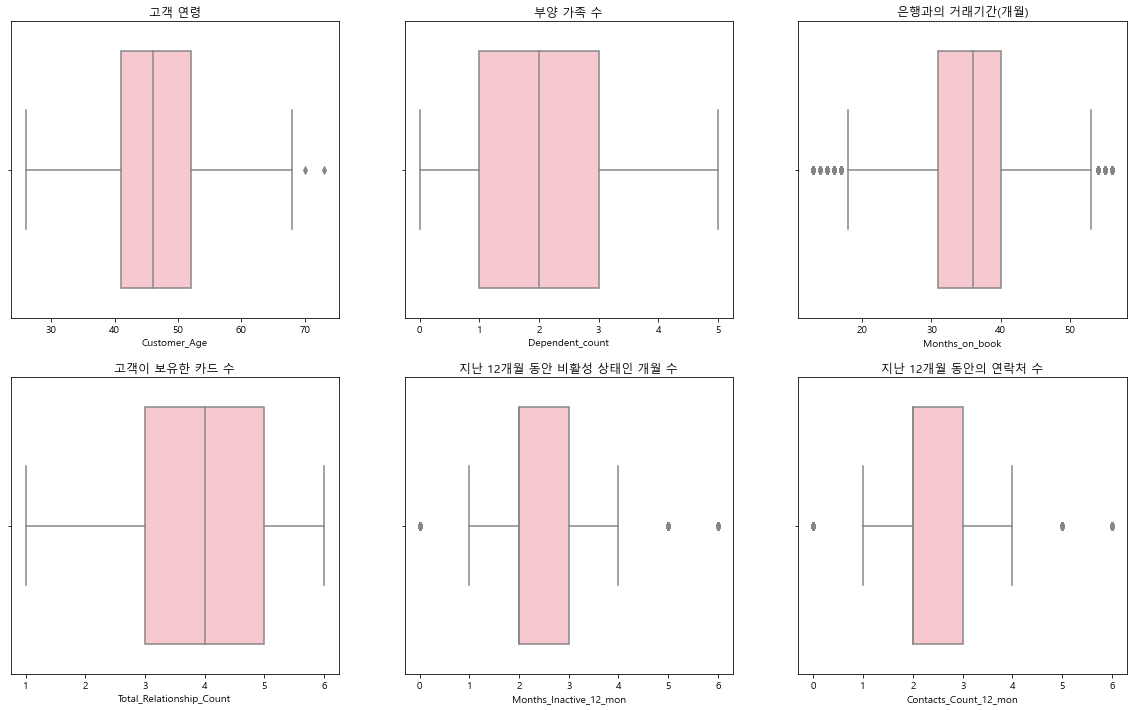

In [29]:
# figure, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3)
# figure.set_size_inches(20,12)

# sns.boxplot(data=df, x='Customer_Age', ax=ax1, color="pink")
# sns.boxplot(data=df, x='Dependent_count', ax=ax2, color="pink")
# sns.boxplot(data=df, x='Months_on_book', ax=ax3, color="pink")
# sns.boxplot(data=df, x='Total_Relationship_Count', ax=ax4, color="pink")
# sns.boxplot(data=df, x='Months_Inactive_12_mon', ax=ax5, color="pink")
# sns.boxplot(data=df, x='Contacts_Count_12_mon', ax=ax6, color="pink")

# ax1.set(title='고객 연령')
# ax2.set(title='부양 가족 수')
# ax3.set(title='은행과의 거래기간(개월)')
# ax4.set(title='고객이 보유한 카드 수')
# ax5.set(title='지난 12개월 동안 비활성 상태인 개월 수')
# ax6.set(title='지난 12개월 동안의 연락처 수')

[Text(0.5, 1.0, '거래 금액의 변동 (Q1 대비 Q4)')]

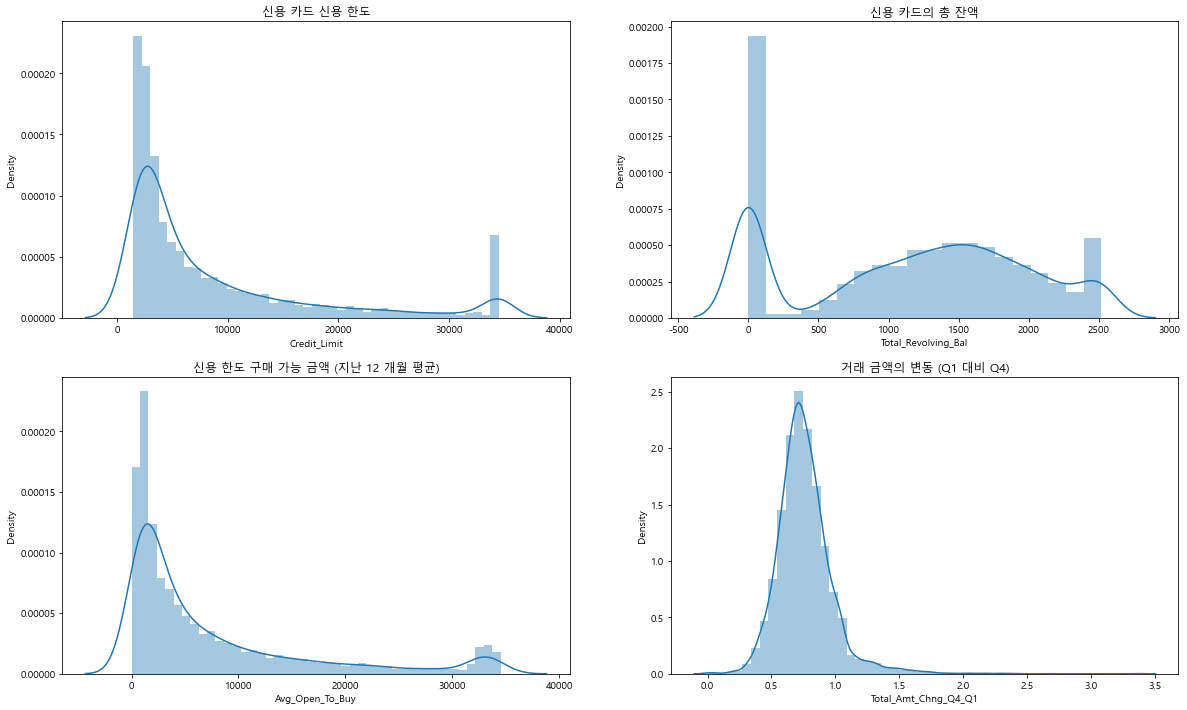

In [32]:
figure, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(20,12)

sns.distplot(df['Credit_Limit'], ax=ax1)
sns.distplot(df['Total_Revolving_Bal'], ax=ax2)
sns.distplot(df['Avg_Open_To_Buy'], ax=ax3)
sns.distplot(df['Total_Amt_Chng_Q4_Q1'], ax=ax4)

ax1.set(title='신용 카드 신용 한도')
ax2.set(title='신용 카드의 총 잔액')
ax3.set(title='신용 한도 구매 가능 금액 (지난 12 개월 평균)')
ax4.set(title='거래 금액의 변동 (Q1 대비 Q4)')

[Text(0.5, 1.0, '거래 금액의 변동 (Q1 대비 Q4)')]

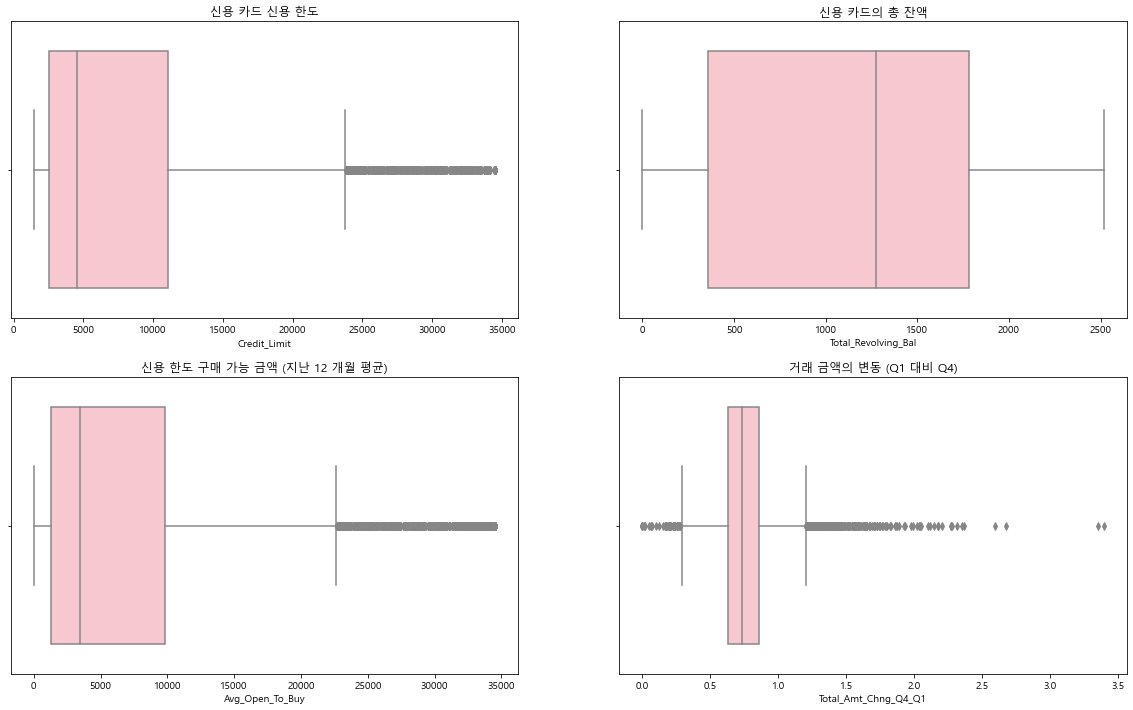

In [48]:
figure, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(20,12)

sns.boxplot(data=df, x='Credit_Limit', ax=ax1, color="pink")
sns.boxplot(data=df, x='Total_Revolving_Bal', ax=ax2, color="pink")
sns.boxplot(data=df, x='Avg_Open_To_Buy', ax=ax3, color="pink")
sns.boxplot(data=df, x='Total_Amt_Chng_Q4_Q1', ax=ax4, color="pink")

ax1.set(title='신용 카드 신용 한도')
ax2.set(title='신용 카드의 총 잔액')
ax3.set(title='신용 한도 구매 가능 금액 (지난 12 개월 평균)')
ax4.set(title='거래 금액의 변동 (Q1 대비 Q4)')

In [57]:
df[df['Total_Amt_Chng_Q4_Q1'] > 3.0]

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
8,710930508,Existing Customer,37,M,3,Uneducated,Single,$60K - $80K,Blue,36,...,2,0,22352.0,2517,19835.0,3.355,1350,24,1.182,0.113
12,710599683,Existing Customer,56,M,1,College,Single,$80K - $120K,Blue,36,...,6,0,11751.0,0,11751.0,3.397,1539,17,3.250,0.000


[Text(0.5, 1.0, '평균 카드 사용률')]

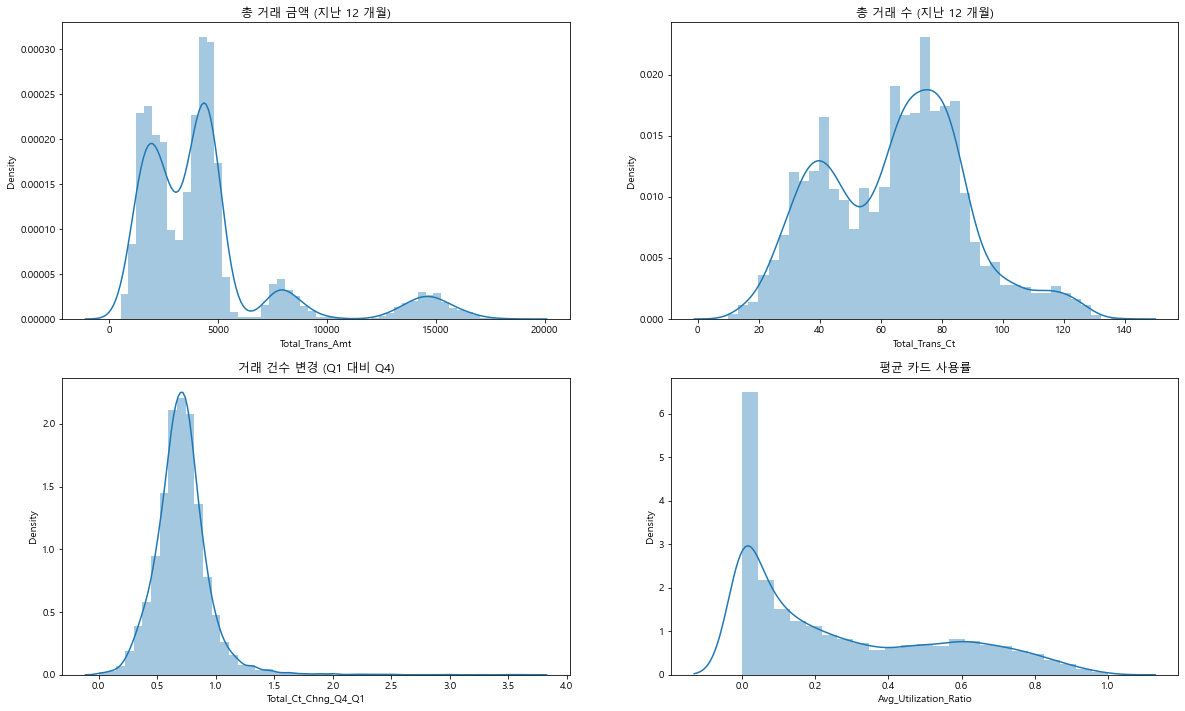

In [21]:
figure, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(20,12)

sns.distplot(df['Total_Trans_Amt'], ax=ax1)
sns.distplot(df['Total_Trans_Ct'], ax=ax2)
sns.distplot(df['Total_Ct_Chng_Q4_Q1'], ax=ax3)
sns.distplot(df['Avg_Utilization_Ratio'], ax=ax4)

ax1.set(title='총 거래 금액 (지난 12 개월)')
ax2.set(title='총 거래 수 (지난 12 개월)')
ax3.set(title='거래 건수 변경 (Q1 대비 Q4)')
ax4.set(title='평균 카드 사용률')

[Text(0.5, 1.0, '평균 카드 사용률')]

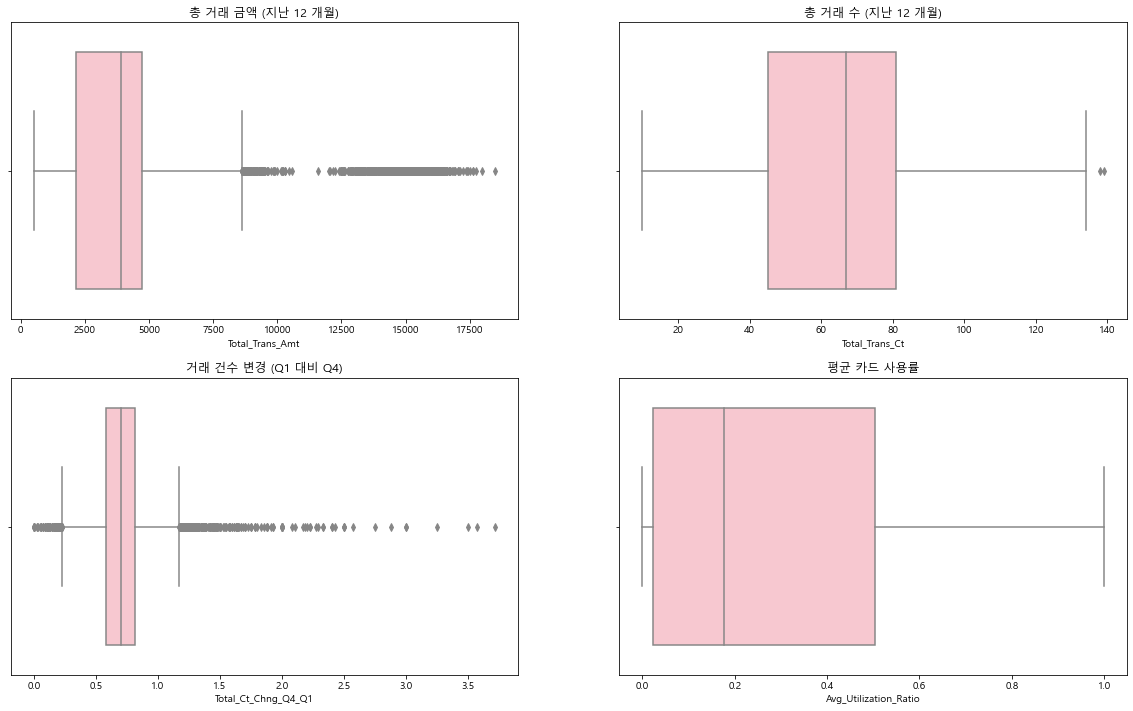

In [58]:
figure, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(20,12)

sns.boxplot(data=df, x='Total_Trans_Amt', ax=ax1, color="pink")
sns.boxplot(data=df, x='Total_Trans_Ct', ax=ax2, color="pink")
sns.boxplot(data=df, x='Total_Ct_Chng_Q4_Q1', ax=ax3, color="pink")
sns.boxplot(data=df, x='Avg_Utilization_Ratio', ax=ax4, color="pink")

ax1.set(title='총 거래 금액 (지난 12 개월)')
ax2.set(title='총 거래 수 (지난 12 개월)')
ax3.set(title='거래 건수 변경 (Q1 대비 Q4)')
ax4.set(title='평균 카드 사용률')

- EDA를 통해 각 변수들을 시각화하여 살펴보고 이상치를 확인했다.
- 이상치들이 더러 있었지만, 비정상적으로 극단적인 이상치(ex, 1000회 이상의 거래 횟수)는 발견되지 않았기에 확인된 이상치는 모두 수용하기로 결정했다.